# 读取数据集
ASD 自闭症谱系障碍

In [66]:
import pandas as pd
import numpy as np
# 读取数据集
# 去掉以@开头的注释、逗号分隔，替换问号为空值nan
df = pd.read_csv("Autism-Child-Data.arff", comment='@', delimiter=',',na_values='?')
df.columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 
              'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender', 
              'ethnicity', 'jundice', 'austim', 'country_of_res', 'used_app_before', 
              'result', 'age_desc', 'relation', 'Class/ASD']

# 数据预处理

In [73]:
from sklearn.preprocessing import LabelEncoder

# 众数填充空值
df = df.fillna(df.mode().iloc[0])

# 将字符类型的值转换为数字
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])

In [74]:
from sklearn.preprocessing import StandardScaler
# 标准化 z-score
scaler = StandardScaler()
df.iloc[:,:-1]  = pd.DataFrame(scaler.fit_transform(df.iloc[:,:-1] ), columns=df.iloc[:,:-1].columns)

# 编写模型（使用了梯度下降）

In [75]:
from sklearn.metrics import confusion_matrix


class MyLogisticRegression:
    def __init__(self, learning_rate=0.001, max_iter=10000):
        # 初始化逻辑回归模型的参数
        self._theta = None
        self.intercept_ = None
        self.coef_ = None
        # 设置学习率和最大迭代次数
        self.learning_rate = learning_rate
        self.max_iter = max_iter

    def _sigmoid(self, z):
        # 定义sigmoid函数，用于输出0-1之间的概率值
        return 1. / (1. + np.exp(-z))

    def fit(self, x_train, y_train):
        
        # 逻辑回归模型的代价函数J
        def J(theta, X_b, y_train):
            # theta: 模型参数，包括截距和系数，通过梯度下降等优化算法不断更新以达到最优值。
            # X_b: 训练集数据，包括n个样本的特征值和1列偏置项，即X_b = [1, x_1, x_2, ..., x_n]。
            # y_train: 训练集标签，包括n个样本的标签值，即y_train = [y_1, y_2, ..., y_n]。
            y_hat = self._sigmoid(X_b.dot(theta)) # 根据当前的模型参数theta和训练数据X_b，计算出每个样本的预测值y_hat（表示模型认为样本属于正例的概率）。这里使用了sigmoid函数来将线性函数值转化为概率值。
            return - np.sum(y_train*np.log(y_hat) + (1-y_train)*np.log(1-y_hat)) / len(y_train)
            
            # 1、 对数似然函数可以用以下式子表示：log L = sum( y_train*log(y_hat) + (1-y_train)*log(1-y_hat) )  其中，y_train表示样本的真实标签，y_hat表示模型输出的概率。
            #     当y_train为1时，对应的一项为y_train*log(y_hat)，表示模型预测为1的概率与真实标签为1的概率相乘取对数；
            #     当y_train为0时，对应的一项为(1-y_train)*log(1-y_hat)，表示模型预测为0的概率与真实标签为0的概率相乘取对数。
            
            # 2、 根据最大似然估计的原理，我们需要最大化正确预测的概率，即最大化对数似然函数
            #     由于我们是最大化对数似然函数，而不是最小化，所以在求解过程中需要将函数取负。因此，最终的损失函数可以表示为：
            #     J = -1/m * sum( y_train*log(y_hat) + (1-y_train)*log(1-y_hat) ) 其中，m为样本数量，即训练集的大小。这个式子就是交叉熵损失函数的标准形式。
            
            
        # 这段实现的是损失函数对模型参数的梯度，即代价函数J(θ)对模型参数θ的偏导数∂J(θ)/∂θ。
        # 通过梯度下降算法来更新模型参数，使得代价函数最小化。
        def dJ(theta, X_b, y_train):
            y_hat = self._sigmoid(X_b.dot(theta))
            return X_b.T.dot(y_hat - y_train) / len(y_train)
        # 每次迭代中，我们先计算损失函数对模型参数的梯度，然后使用梯度下降法更新模型参数，直到代价函数不再降低或达到最大迭代次数为止。

        # 对训练集添加偏置项，并随机初始化模型参数
        X_b = np.hstack([np.ones((len(x_train), 1)), x_train])
        self._theta = np.random.randn(X_b.shape[1])
        
        # 使用梯度下降法来训练模型，使得代价函数不断降低直至最小值
        iter_num = 0
        while iter_num < self.max_iter: # 在迭代次数小于最大迭代次数（self.max_iter）时进行循环
            iter_num += 1
            last_theta = self._theta # 首先将当前的参数（theta）赋值给last_theta
            self._theta = self._theta - self.learning_rate * \
                          dJ(self._theta, X_b, y_train)    # 然后根据当前参数和梯度下降的公式来更新参数self._theta。其中，学习率为self.learning_rate，dJ是代价函数J的梯度。
                          
            # 当前代价函数值和上一次的代价函数值之差小于1e-7时停止迭代
            if (abs(J(self._theta, X_b, y_train) - J(last_theta, X_b, y_train)) < 1e-7):
                break
            
        # 将最终得到的参数分别赋值给拟合结果的属性
        self.intercept_ = self._theta[0] # 将得到的参数self._theta中的【截距项】（self.theta[0]）赋值给属性self.intercept
        self.coef_ = self._theta[1:] # 将得到的参数self._theta中的【系数项】（self.theta[1:]）赋值给属性self.coef
        return self

    def predict(self, x_predict):
        # 对待预测的数据添加偏置项，并根据阈值0.5来将概率值转换成二分类标签
        
        #添加偏置项
        X_b = np.hstack([np.ones((len(x_predict), 1)), x_predict])
        
        # 使用已训练好的参数预测标签
        y_predict = self._sigmoid(X_b.dot(self._theta))
        y_predict = np.array(y_predict >= 0.5, dtype='int') # 大于等于0.5的概率值转换为1，小于0.5的概率值转换为0
        
        return y_predict

    def score(self, x_test, y_test):
        # 根据预测结果计算混淆矩阵并返回
        y_predict = self.predict(x_test)
        cm = confusion_matrix(y_test, y_predict)
        return cm

    def __repr__(self):
        return "LogisticRegression()"



# 训练模型并且使用k-fold交叉验证

In [76]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# k-fold 交叉验证会将原始数据集分为5个子集，然后将其中1个子集作为测试集，剩余的 4 个作为训练集，这样可以得到 5 组不同的训练集和测试集，从而可以进行 5 次训练和测试。
# 在每次训练和测试时，都会选择不同的部分作为测试集，最终将这 5 次训练和测试的结果进行平均，得到一个最终的评估结果。

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# 将评估指标保存到字典中
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': []}

# 创建模型实例
logistic = MyLogisticRegression()

# 定义k-fold交叉验证器
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用k-fold交叉验证进行实验
for train_index, test_index in kf.split(X):
    # 划分训练集和测试集
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # 训练模型
    logistic.fit(X_train, y_train)
    
    # 计算预测结果
    y_pred = logistic.predict(X_test)
    
    # 计算评估指标
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['f1_score'].append(f1_score(y_test, y_pred))
    
# 输出评估指标的平均值
print('Accuracy:', np.mean(metrics['accuracy']))
print('Precision:', np.mean(metrics['precision']))
print('Recall:', np.mean(metrics['recall']))
print('F1 score:', np.mean(metrics['f1_score']))


Accuracy: 0.882875511396844
Precision: 0.8471646887595163
Recall: 0.9239173342621617
F1 score: 0.8833402576715779


# 实验结果可视化

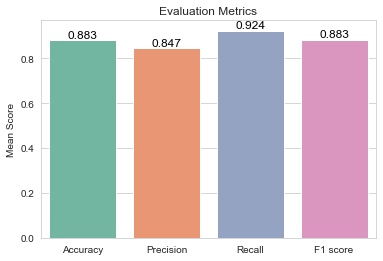

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# 创建Seaborn数据帧并添加平均评估指标
df_metrics = pd.DataFrame({'metrics': ['Accuracy', 'Precision', 'Recall', 'F1 score'],
                           'mean': [np.mean(metrics['accuracy']), np.mean(metrics['precision']),
                                    np.mean(metrics['recall']), np.mean(metrics['f1_score'])]})

# 使用Seaborn绘制柱状图
sns.set_style("whitegrid")
ax = sns.barplot(x='metrics', y='mean', data=df_metrics, palette='Set2')
ax.set_title('Evaluation Metrics')
ax.set_xlabel('')
ax.set_ylabel('Mean Score')

# 标出柱子上的值
for i, v in enumerate(df_metrics['mean']):
    ax.text(i, v + 0.01, f"{v:.3f}", color='black', ha='center', fontsize=12)

# 显示图形
plt.show()


Accuracy (准确率)：模型在预测中正确分类的样本数与总样本数的比例，该模型的准确率为 0.883。
Precision (精确率)：模型预测为ASD谱系障碍并且真实为ASD谱系障碍的样本数与预测为ASD谱系障碍的样本数之比，该模型的精确率为 0.847。【预测为自闭症的里面，预测对了的】
Recall (召回率)：模型预测为ASD谱系障碍并且真实为ASD谱系障碍的样本数与真实为ASD谱系障碍的样本数之比，该模型的召回率为 0.924，说明模型对于ASD谱系障碍的识别能力较强。【所有自闭症患者中，判断出来了的】
F1 score (F1得分)：精确率和召回率的调和平均值，该模型的F1得分为 0.883。

92%的自闭症患者都能被正确找出来！